# Introduction to Word Embeddings and Language Models
_Python Version_
<div>
<img src="media/word_embedding_cover_art.png" width="1000"/>
</div>

_This notebook was prepared by Laura Nelson in collaboration with [UBC COMET](https://comet.arts.ubc.ca/) team members: Jonathan Graves, Angela Chen and Anneke Dresselhuis_

## Prerequisites

1. Some familiarity programming in R
2. Some familarity with natural language processing
3. No computational text experience necessary!

## Learning outcomes

In the notebook you will 

1. Familiarize yourself with concepts such as word embeddings (WE) vector-space model of language, natural language processing (NLP) and how they relate to small and large language models (LMs) 
1. Import and pre-process a textual dataset for use in word embedding 
1. Use word2vec to build a simple language model for examining patterns and biases textual datasets
1. Identify and select methods for saving and loading models
1. Use critical and reflexive thinking to gain a deeper understanding of how the inherent social and cultural biases of language are reproduced and mapped into language computation models

## Outline

The goal of this notebook is to demystify some of the technical aspects of language models and to invite learners to start thinking about how these important tools function in society.

In particular, this lesson is designed to explore features of word embeddings produced through the word2vec model. The questions we ask in this lesson are guided by Ben Schmidt's blog post, [Rejecting the Gender Binary]("http://bookworm.benschmidt.org/posts/2015-10-30-rejecting-the-gender-binary.html).

The primary corpus we will use consists of the <a href="http://txtlab.org/?p=601">150 English-language novels</a> made available by the <em>.txtLab</em> at McGill University. We also look at a <a href="http://ryanheuser.org/word-vectors-1/">word2Vec model trained on the ECCO-TCP corpus</a> of 2,350 eighteenth-century literary texts made available by Ryan Heuser. (Note that the number of terms in the model has been shortened by half in order to conserve memory.)

## Key Terms
Before we dive in, feel free to familiarize yourself with the following key terms and how they relate to each other.
</div>
<img src="media/ai_key_terms.png" width="500"/>
</div>

**Artificial Intelligence (AI):** is a broad category that includes the study and development of computer systems that can copy intelligent human behaviour (adapted from [_Oxford Learners Dictionary_](https://www.oxfordlearnersdictionaries.com/definition/english/ai#:~:text=%2F%CB%8Ce%C9%AA%20%CB%88a%C9%AA%2F-,%2F%CB%8Ce%C9%AA%20%CB%88a%C9%AA%2F,way%20a%20human%20brain%20does.))

**Machine Learning (ML):** is branch of AI which is uses statistical methods to imitate the way that humans learn (adapted from [_IBM_](https://www.ibm.com/topics/machine-learning))

**Natural Language Processing (NLP):** is branch of AI which focuses on training computers to interpret human text and spoken words (adapted from [_IBM_](https://www.ibm.com/topics/natural-language-processing#:~:text=the%20next%20step-,What%20is%20natural%20language%20processing%3F,same%20way%20human%20beings%20can.))

**Word Embeddings (WE):** is one part of NLP where human words are converted into numerical representations (usually vectors) in order for computers to be able to understand them (adapted from [_Turing_](https://www.turing.com/kb/guide-on-word-embeddings-in-nlp))

**word2vec:** is an NLP technique that is commonly used to generate word embeddings

## What are Word Embeddings?

Building off of the definition above, word embeddings are one way that humans can represent language in a way that is legible to a machine. More specifically, word embeddings are an NLP approach that use vectors to store textual data in multiple dimensions; by existing in the multi-dimensional space of vectors, word embeddings are able to include important semantic information within a given numeric representation.

For example, if we are trying to answer a research question about how popular a term is on the web at a given time, we might use a simple word frequency analysis to count how many times the word "candidate" shows up in tweets during a defined electoral period. However, if we wanted to gain a more nuanced understanding of what kind of language, biases or attitudes contextualize the term, "candidate" in discourse, we would need to use a method like word embedding to encode meaning into our understanding of how people have talked about candidates over time. Instead of describing our text as a series of word counts, we would treat our text like coordinates in space, where similar words and concepts are closer to each other, and words that are different from each other are further away.

![Comparing word frequency count and word embedding methods](media/word_frequency_vs_word_embeddings.png)

## What are Word Embeddings?

Building off of the definition above, word embeddings are one way that humans can represent language in a way that is legible to a machine. More specifically, word embeddings are an NLP approach that use vectors to store textual data in multiple dimensions; by existing in the multi-dimensional space of vectors, word embeddings are able to include important semantic information within a given numeric representation.

For example, if we are trying to answer a research question about how popular a term is on the web at a given time, we might use a simple word frequency analysis to count how many times the word "candidate" shows up in tweets during a defined electoral period. However, if we wanted to gain a more nuanced understanding of what kind of language, biases or attitudes contextualize the term, "candidate" in discourse, we would need to use a method like word embedding to encode meaning into our understanding of how people have talked about candidates over time. Instead of describing our text as a series of word counts, we would treat our text like coordinates in space, where similar words and concepts are closer to each other, and words that are different from each other are further away.

![Comparing word frequency count and word embedding methods](media/word_frequency_vs_word_embeddings.png)


For example, in the visualization above, a word frequency count returns the number of times the word "candidate" or "candidates" is used in a sample text corpus. When a word embedding is made from the same text corpus, we are able to map related concepts and phrases that are closely related to "candidate" as neighbours, while other words and phrases such as "experimental study" (which refers to the research paper in question, and not to candidates specifically) are further away. 

Here is another example of how different, but related words might be represented in a word embedding:
<img src = "media/w2v-Analogies.png">

## Making a Word Embedding
So, how do word embeddings work? To make a word embedding, an input word gets compressed into a dense vector.

![Creating a word embedding vector](media/creating_a_word_embedding.png)

The magic and mystery of the word embedding process is that often the vectors produced during the model embed qualities of a word or phrase that are not interpretable by humans. However, for our purposes, having the text in vector format is all we need. With this format, we can perform tests like cosine similarity and other kinds of operations. Such operations can reveal many different kinds of relationships between words, as we'll examine a bit later.

## Using word2vec

Word2vec is one NLP technique that is commonly used to generate word embeddings. More precisely, word2vec is an algorithmic learning tool rather than a specific neural net that is already trained. The example we will be working through today has been made using this tool.

The series of algorithms inside of the word2vec model try to describe and acquire parameters for a given word in terms of the text that appear immediately to the right and left in actual sentences. Essentially, it learns how to predict text.

Without going too deep into the algorithm, suffice it to say that it involves a two-step process: 

1. First, the input word gets compressed into a dense vector, as seen in the simplified diagram, "Creating a Word Embedding," above. 
2. Second, the vector gets decoded into the set of context words. Keywords that appear within similar contexts will have similar vector representations in between steps. 

Imagine that each word in a novel has its meaning determined by the ones that surround it in a limited window. For example, in Moby Dick's first sentence, “me” is paired on either side by “Call” and “Ishmael.” After observing the windows around every word in the novel (or many novels), the computer will notice a pattern in which “me” falls between similar pairs of words to “her,” “him,” or “them.” Of course, the computer had gone through a similar process over the words “Call” and “Ishmael,” for which “me” is reciprocally part of their contexts. This chaining of signifiers to one another mirrors some of humanists' most sophisticated interpretative frameworks of language.

The two main model architectures of word2vec are **Continuous Bag of Words (CBOW)** and **Skip-Gram**, which can be distinguished partly by their input and output during training. 

**CBOW** takes the context words (for example, "Call","Ishmael") as a single input and tries to predict the word of interest ("me").

<div>
<img src="media/CBOW.gif" width="500"/>
</div>

**Skip-Gram** does the opposite, taking a word of interest as its input (for example, "me") and tries to learn how to predict its context words ("Call","Ishmael"). 

<div>
<img src="media/SG.gif" width="500"/>
</div>

In general, CBOW is is faster and does well with frequent words, while Skip-Gram potentially represents rare words better.

Since the word embedding is a vector, we are able perform tests like cosine similarity (which we'll learn more about in a bit!) and other kinds of operations. Those operations can reveal many different kinds of relationships between words, as we shall see.

## Bias and Language Models

You might already be piecing together that the encoding of meaning in word embeddings is entirely shaped by the patterns of language use captured in the training data. That is, what is included in a word embedding directly reflects the complex social and cultural biases of everyday human language - in fact, exploring how these biases function and change over time (as we will do later) is one of the most interesting ways to use word embeddings in social research.

#### It is simply impossible to have a bias-free language model (LM). 

In LMs, bias is not a bug or a glitch, rather, it is an essential feature that is baked into the fundamental structure. For example, LMs are not outside of learning and absorbing the pejorative dimensions of language which in turn, can result in reproducing harmful correlations of meaning for words about race, class or gender (among others). When unchecked, these harms can be “amplified in downstream applications of word embeddings” ([Arseniev-Koehler & Foster, 2020, p. 1](https://osf.io/preprints/socarxiv/b8kud/)).

Just like any other computational model, it is important to critically engage with the source and context of the training data. One way that [Schiffers, Kern and Hienert](https://arxiv.org/abs/2302.06174v1) suggest doing this is by using domain specific models (2023). Working with models that understand the nuances of your particular topic or field can better account for "specialized vocabulary and semantic relationships" that can help make applications of WE more effective. 

## Preparing for our Analysis
#### Word2vec Features

**Here are a few features of the word2vec tool that we can use to customize our analysis:**

* `size`: Number of dimensions for word embedding model</li>
* `window`: Number of context words to observe in each direction</li>
* `min_count`: Minimum frequency for words included in model</li>
* `sg` (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram</li>
* `alpha`: Learning rate (initial); prevents model from over-correcting, enables finer tuning</li>
* `iterations`: Number of passes through dataset</li>
* `batch size`: Number of words to sample from data during each pass</li>

Note: the script uses default value for each argument.

**Some limitations of the word2vec Model**

* Within word2vec, common articles or conjunctions, called **stop words** such as "the" and "and," may not provide very rich contextual information for a given word, and may need additional subsampling or to be combined into a word phrase (Anwla, 2019).
* word2vec isn't always the best at handling out-of-vocabulary words well (Chandran, 2021).

Let's begin our analysis!

## Excercise #1: Eggs, Sausages and Bacon
<div>
<img src="media/eggs_bacon_sausages.png" width="750"/>
<div>

To begin, we are going to load a few packages that are necessary for our analysis. Please run the code cells below.

In [19]:
%pylab inline
matplotlib.style.use('ggplot')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['indices']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


#### Create a Document-Term Matrix (DTM) with a Few Pseudo-Texts
To start off, we're going to create a mini dataframe based on the use of the words "eggs," "sausages" and "bacon" found in three different novels: A, B and C.


In [20]:
# dataframes!
import pandas

# Construct dataframe with three novels each containing three words
columns = ['eggs','sausage','bacon']
indices = ['Novel A', 'Novel B', 'Novel C']
dtm = [[50,60,60],[90,10,10], [20,70,70]]
dtm_df = pandas.DataFrame(dtm, columns = columns, index = indices)

# Show dataframe
dtm_df

,eggs,sausage,bacon
Novel A,50,60,60
Novel B,90,10,10
Novel C,20,70,70


### Visualize

(Text(0.5, 0, 'eggs'), Text(0, 0.5, 'sausage'))

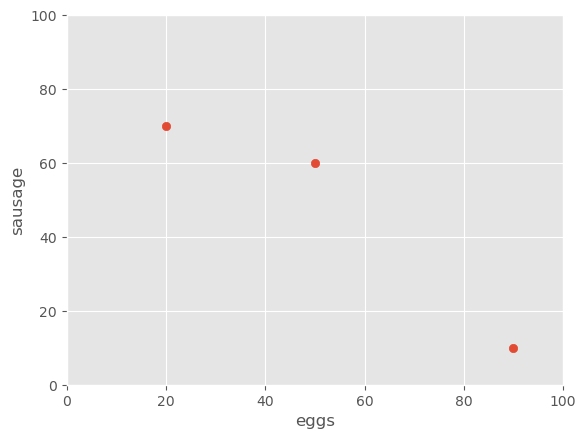

In [21]:
# Plot our points
scatter(dtm_df['eggs'], dtm_df['sausage'])

# Make the graph look good
xlim([0,100]), ylim([0,100])
xlabel('eggs'), ylabel('sausage')

### Vectors

At a glance, a couple of points are lying closer to one another. We used the word frequencies of just two of the three words (eggs and sausages) in order to plot our texts in a two-dimensional plane. The term frequency "summaries" of <i>Novel A</i> & <i>Novel C</i> are pretty similar to one another: they both share a major concern with "sausage", whereas <i>Novel B</i> seems to focus primarily on "eggs."

This raises a question: how can we operationalize our intuition that the spatial distance presented here expresses topical similarity?

## Cosine Similarity
The most common measurement of distance between points is their [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity). Cosine similarity can operate on textual data that contain word vectors and allows us to identify how similar documents are to each other, for example. Cosine Similarity thus helps us understand how much content overlap a set of documents have with one another. For example, imagine that we were to draw an arrow from the origin of the graph - point (0,0) - to the dot representing each text. This arrow is called a _vector_. 

Mathematically, this can be represented as: 
<div>
<img src='media/Dot-Product.png' >

Using our example above, we can see that the angle from (0,0) between Novel C and Novel A (orange triangle) is smaller than between Novel A and Novel B (navy triangle) or between Novel C and Novel B (both triangles together).
<div>
<img src="media/annotated_scatterplot.png" width="400"/>
<div>

Because this similarity measurement uses the cosine of the angle between vectors, the magnitude is not a matter of concern (this feature is really helpful for text vectors that can often be really long!). Instead, the output of cosine similarity yields a value between 0 and 1 (we don't have to work with something confusing like 18º!) that can be easily interpreted and compared - and thus we can also avoid the troubles associated with other dimensional distance measures such as [Euclidean Distance](https://en.wikipedia.org/wiki/Euclidean_distance).

### Calculating Cosine Distance

In [22]:
# Although we want the Cosine Distance, it is mathematically simpler to calculate its opposite: Cosine Similarity

from sklearn.metrics.pairwise import cosine_similarity

In [23]:
# So we will subtract the similarities from 1

cos_sim = cosine_similarity(dtm_df)

In [24]:
# Make it a little easier to read by rounding the values

np.round(cos_sim, 2)

# Label the dataframe rows and columns with eggs, sausage and bacon

frame_2 = np.round(cos_sim, 2)
frame_2 = pandas.DataFrame(frame_2, columns = indices, index = indices)
frame_2

,Novel A,Novel B,Novel C
Novel A,1.00,0.64,0.95
Novel B,0.64,1.00,0.35
Novel C,0.95,0.35,1.00


_From this output table, which novels appear to be more similar to each other?_

## Excercise #2: Working with 18th Century Literature

<div>
<img src="media/18th_cent_literature.png" width="750"/>
<div>

In [25]:
# Compare the distance between novels

filelist = ['txtlab_Novel450_English/EN_1850_Hawthorne,Nathaniel_TheScarletLetter_Novel.txt',
            'txtlab_Novel450_English/EN_1851_Hawthorne,Nathaniel_TheHouseoftheSevenGables_Novel.txt',
            'txtlab_Novel450_English/EN_1920_Fitzgerald,FScott_ThisSideofParadise_Novel.txt',
            'txtlab_Novel450_English/EN_1922_Fitzgerald,FScott_TheBeautifulandtheDamned_Novel.txt',
            'txtlab_Novel450_English/EN_1811_Austen,Jane_SenseandSensibility_Novel.txt',
            'txtlab_Novel450_English/EN_1813_Austen,Jane_PrideandPrejudice_Novel.txt']

novel_names = ['Hawthorne: Scarlet Letter',
           'Hawthorne: Seven Gables',
           'Fitzgerald: This Side of Paradise',
           'Fitzgerald: Beautiful and the Damned',
           'Austen: Sense and Sensibility',
           'Austen: Pride and Prejudice']

text_list = []

for file in filelist:
    with open(file, 'r', encoding = 'utf-8') as myfile:
        text_list.append(myfile.read()) 

# Import the function CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english', min_df = 3, binary=True)

novel_dtm = cv.fit_transform(text_list).toarray()
feature_list = cv.get_feature_names_out()
dtm_df_novel = pandas.DataFrame(novel_dtm, columns = feature_list, index = novel_names)
dtm_df_novel

,abandoned,abhorrence,abide,abilities,ability,able,aboard,abode,abominable,abominably,...,yielding,yonder,york,young,younger,youngest,youth,youthful,youths,zeal
Hawthorne: Scarlet Letter,1,1,1,1,1,1,1,1,0,0,...,1,1,1,1,1,1,1,1,0,1
Hawthorne: Seven Gables,1,0,1,1,1,1,1,1,1,0,...,1,1,0,1,1,1,1,1,0,1
Fitzgerald: This Side of Paradise,1,0,0,1,1,1,0,0,0,0,...,0,0,1,1,1,0,1,1,1,0
Fitzgerald: Beautiful and the Damned,1,1,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,1,0
Austen: Sense and Sensibility,1,1,0,1,1,1,0,1,0,1,...,0,0,0,1,1,1,1,1,0,1
Austen: Pride and Prejudice,0,1,1,1,0,1,0,1,1,1,...,1,0,1,1,1,1,1,0,1,0


In [26]:
cos_sim_novel = cosine_similarity(dtm_df_novel)
cos_sim_novel = np.round(cos_sim_novel, 2)

In [27]:
cos_df = pandas.DataFrame(cos_sim_novel, columns = novel_names, index = novel_names)
cos_df

,Hawthorne: Scarlet Letter,Hawthorne: Seven Gables,Fitzgerald: This Side of Paradise,Fitzgerald: Beautiful and the Damned,Austen: Sense and Sensibility,Austen: Pride and Prejudice
Hawthorne: Scarlet Letter,1.00,0.80,0.69,0.75,0.67,0.67
Hawthorne: Seven Gables,0.80,1.00,0.74,0.80,0.70,0.70
Fitzgerald: This Side of Paradise,0.69,0.74,1.00,0.78,0.62,0.61
Fitzgerald: Beautiful and the Damned,0.75,0.80,0.78,1.00,0.69,0.68
Austen: Sense and Sensibility,0.67,0.70,0.62,0.69,1.00,0.81
Austen: Pride and Prejudice,0.67,0.70,0.61,0.68,0.81,1.00


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


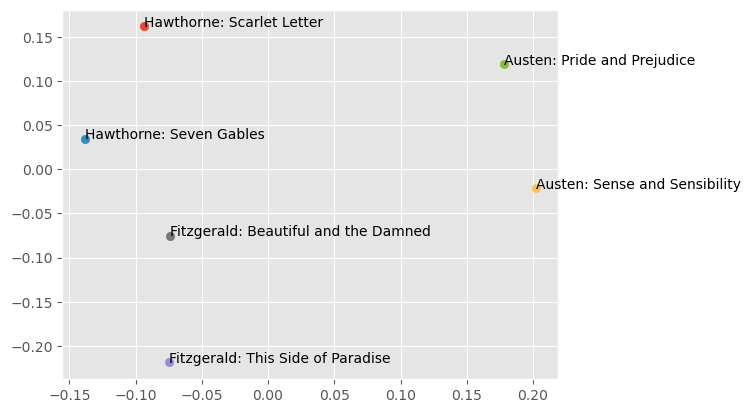

In [28]:
# Visualizing differences

from sklearn.manifold import MDS

# Two components as we're plotting points in a two-dimensional plane
# "Precomputed" because we provide a distance matrix
# We will also specify `random_state` so that the plot is reproducible.

# Transform cosine similarity to cosine distance
cos_dist = 1 - cosine_similarity(dtm_df_novel)

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(cos_dist)  # shape (n_components, n_samples)
xs, ys = pos[:, 0], pos[:, 1]

for x, y, name in zip(xs, ys, novel_names):
    plt.scatter(x, y)
    plt.text(x, y, name)

plt.show()

The above method has a broad range of applications, such as unsupervised clustering. Common techniques include <a href = "https://en.wikipedia.org/wiki/K-means_clustering">K-Means Clustering</a> and <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering">Hierarchical Dendrograms</a>. These attempt to identify groups of texts with shared content, based on these kinds of distance measures.

Here's an example of a dendrogram based on these six novels:

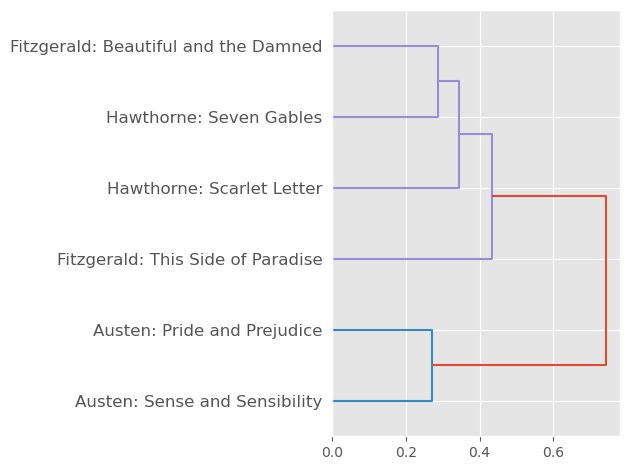

In [29]:
from scipy.cluster.hierarchy import ward, dendrogram
linkage_matrix = ward(cos_dist)

dendrogram(linkage_matrix, orientation="right", labels=novel_names)

plt.tight_layout()  # fixes margins

plt.show()

#### Vector Semantics

We can also turn this logic on its head. Rather than produce vectors representing texts based on their words, we will produce vectors for the words based on their contexts.

In [30]:
# Turn our DTM sideways

dtm_df_novel.T.head()

,Hawthorne: Scarlet Letter,Hawthorne: Seven Gables,Fitzgerald: This Side of Paradise,Fitzgerald: Beautiful and the Damned,Austen: Sense and Sensibility,Austen: Pride and Prejudice
abandoned,1,1,1,1,1,0
abhorrence,1,0,0,1,1,1
abide,1,1,0,0,0,1
abilities,1,1,1,0,1,1
ability,1,1,1,1,1,0


In [31]:
# Find the Cosine Distances between pairs of word-vectors

cos_sim_words = cosine_similarity(dtm_df_novel.T)

In [32]:
# In readable format

np.round(cos_sim_words, 2)

array([[1.  , 0.67, 0.52, ..., 0.89, 0.52, 0.77],
       [0.67, 1.  , 0.58, ..., 0.5 , 0.58, 0.58],
       [0.52, 0.58, 1.  , ..., 0.58, 0.33, 0.67],
       ...,
       [0.89, 0.5 , 0.58, ..., 1.  , 0.29, 0.87],
       [0.52, 0.58, 0.33, ..., 0.29, 1.  , 0.  ],
       [0.77, 0.58, 0.67, ..., 0.87, 0.  , 1.  ]])

Theoretically you could visualize and cluster these as well - but this takes a lot of computational power!

We'll thus turn to the machine learning version: word embeddings

## Exercise #3: Using word2vec with 150 English Novels
<div>
<img src="media/150_novels.png" width="750"/>
<div>

In this exercise, we'll use an English-language subset from a dataset about novels created by [Andrew Piper](https://www.mcgill.ca/langlitcultures/andrew-piper). Specifically we'll look at 150 novels by British and American authors spanning the years 1771-1930. These texts reside on disk, each in a separate plaintext file. Metadata is contained in a spreadsheet distributed with the novel files.

#### Metadata Columns
<ol><li>Filename: Name of file on disk</li>
<li>ID: Unique ID in Piper corpus</li>
<li>Language: Language of novel</li>
<li>Date: Initial publication date</li>
<li>Title: Title of novel</li>
<li>Gender: Authorial gender</li>
<li>Person: Textual perspective</li>
<li>Length: Number of tokens in novel</li></ol>

In [33]:
# Data Wrangling

import os
import numpy as np
import pandas
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise
from sklearn.manifold import MDS, TSNE

In [34]:
# Natural Language Processing

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

ModuleNotFoundError: No module named 'nltk'

In [ ]:
# New libarary (not in Anaconda: gensim)
import gensim

#### Import Corpus

In [ ]:
# Custom Tokenizer for Classroom Use

def fast_tokenize(text):
    
    # Get a list of punctuation marks
    from string import punctuation
    
    lower_case = text.lower()
    
    # Iterate through text removing punctuation characters
    no_punct = "".join([char for char in lower_case if char not in punctuation])
    
    # Split text over whitespace into list of words
    tokens = no_punct.split()
    
    return tokens

#### Import Metadata

In [ ]:
# Import Metadata into Pandas Dataframe

meta_df = pandas.read_csv('resources/txtlab_Novel450_English.csv', encoding = 'utf-8')

In [ ]:
# Check Metadata

meta_df.head()

In [ ]:
# Set location of corpus folder

fiction_folder = 'txtlab_Novel450_English/'

In [ ]:
import os

# Create an empty list to store the text of each novel
novel_list = []

# Iterate through filenames in 'fiction_folder'
for filename in os.listdir(fiction_folder):
    file_path = os.path.join(fiction_folder, filename)
    
    try:
        # Attempt to read the novel text as a string using utf-8 encoding
        with open(file_path, 'r', encoding='utf-8') as file_in:
            this_novel = file_in.read()
        
        # Add novel text as a single string to the master list
        novel_list.append(this_novel)
    
    except UnicodeDecodeError as e:
        # Handle encoding errors by skipping the problematic file
        print(f"UnicodeDecodeError: Unable to read '{filename}' - Skipping this file.")
        continue

# Now 'novel_list' contains the text of all readable novels.


In [ ]:
# Inspect first item in novel_list

novel_list[0][:500]

#### Pre-Processing
word2Vec learns about the relationships among words by observing them in context. This means that we want to split our texts into word-units. However, we  want to maintain sentence boundaries as well, since the last word of the previous sentence might skew the meaning of the next sentence.

Since novels were imported as single strings, we'll first need to divide them into sentences, and second, we'll split each sentence into its own list of words.

In [ ]:
# Split each novel into sentences

sentences = [sentence for novel in novel_list for sentence in sent_tokenize(novel)]

In [ ]:
# Inspect first sentence

sentences[0]

In [ ]:
# Split each sentence into tokens

words_by_sentence = [fast_tokenize(sentence) for sentence in sentences]

In [ ]:
# Remove any sentences that contain zero tokens

words_by_sentence = [sentence for sentence in words_by_sentence if sentence != []]

In [ ]:
# Inspect first sentence

words_by_sentence[0]

#### Training

In [ ]:
# Train word2vec model from txtLab corpus

model = gensim.models.Word2Vec(words_by_sentence, vector_size=100, window=5, \
                               min_count=25, sg=1, alpha=0.025, epochs=5, batch_words=10000)

## Embeddings


In [ ]:
# Return dense word vector

model.wv.get_vector('whale')

## Vector-Space Operations

### Similarity
Since words are represented as dense vectors, we can ask how similiar words' meanings are based on their cosine similarity (essentially how much they overlap). <em>gensim</em> has a few out-of-the-box functions that enable different kinds of comparisons.

In [ ]:
# Find cosine distance between two given word vectors

model.wv.similarity('pride','prejudice')

In [ ]:
# Find nearest word vectors by cosine distance

model.wv.most_similar('pride')

In [ ]:
# Given a list of words, we can ask which doesn't belong

# Finds mean vector of words in list
# and identifies the word further from that mean

model.wv.doesnt_match(['pride','prejudice', 'whale'])

### Multiple Valences
A word embedding may encode both primary and secondary meanings that are both present at the same time. In order to identify secondary meanings in a word, we can subtract the vectors of primary (or simply unwanted) meanings. For example, we may wish to remove the sense of <em>river bank</em> from the word <em>bank</em>. This would be written mathetmatically as <em>RIVER - BANK</em>, which in <em>gensim</em>'s interface lists <em>RIVER</em> as a positive meaning and <em>BANK</em> as a negative one.

In [ ]:
# Get most similar words to BANK, in order to get a sense for its primary meaning

model.wv.most_similar('bank')

In [ ]:
# Remove the sense of "river bank" from "bank" and see what is left

model.wv.most_similar(positive=['bank'], negative=['river'])

### Analogy
Analogies are rendered as simple mathematical operations in vector space. For example, the canonic word2vec analogy <em>MAN is to KING as WOMAN is to ??</em> is rendered as <em>KING - MAN + WOMAN</em>. In the gensim interface, we designate <em>KING</em> and <em>WOMAN</em> as positive terms and <em>MAN</em> as a negative term, since it is subtracted from those.

In [ ]:
# Get most similar words to KING, in order
# to get a sense for its primary meaning

model.wv.most_similar('king')

In [ ]:
# The canonic word2vec analogy: King - Man + Woman -> Queen

model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

### Gendered Vectors
Note that this method uses vector projection, whereas Schmidt had used rejection.

In [ ]:
# Feminine Vector

model.wv.most_similar(positive=['she','her','hers','herself'], negative=['he','him','his','himself'])

In [ ]:
# Masculine Vector

model.wv.most_similar(positive=['he','him','his','himself'], negative=['she','her','hers','herself'])

## Visualization

In [ ]:
# Dictionary of words in model

model.wv.key_to_index

In [ ]:
# Visualizing the whole vocabulary would make it hard to read

len(model.wv.key_to_index)

In [ ]:
# For interpretability, we'll select words that already have a semantic relation

her_tokens = [token for token,weight in model.wv.most_similar(positive=['she','her','hers','herself'], \
                                                       negative=['he','him','his','himself'], topn=50)]

In [ ]:
# Inspect list

her_tokens[:15]

In [ ]:
# Get the vector for each sampled word

vectors = [model.wv.get_vector(word) for word in her_tokens] 

In [ ]:
# Calculate distances among texts in vector space

dist_matrix = pairwise.pairwise_distances(vectors, metric='cosine')
dist_matrix

In [ ]:
# Multi-Dimensional Scaling (Project vectors into 2-D)

mds = MDS(n_components = 2, dissimilarity='precomputed')
embeddings = mds.fit_transform(dist_matrix)

In [ ]:
# Make a pretty graph

_, ax = plt.subplots(figsize=(10,10))
ax.scatter(embeddings[:,0], embeddings[:,1], alpha=0)
for i in range(len(vectors)):
    ax.annotate(her_tokens[i], ((embeddings[i,0], embeddings[i,1])))

In [ ]:
# For comparison, here is the same graph using a masculine-pronoun vector

his_tokens = [token for token,weight in model.wv.most_similar(positive=['he','him','his','himself'], \
                                                       negative=['she','her','hers','herself'], topn=50)]
vectors = [model.wv.get_vector(word) for word in his_tokens]
dist_matrix = pairwise.pairwise_distances(vectors, metric='cosine')
mds = MDS(n_components = 2, dissimilarity='precomputed')
embeddings = mds.fit_transform(dist_matrix)
_, ax = plt.subplots(figsize=(10,10))
ax.scatter(embeddings[:,0], embeddings[:,1], alpha=0)
for i in range(len(vectors)):
    ax.annotate(his_tokens[i], ((embeddings[i,0], embeddings[i,1])))

> <span style="color:#CC7A00" > What kinds of semantic relationships exist in the diagram above? </p>
> <span style="color:#CC7A00" > Are there any words that seem out of place?
</span>

## Saving & Loading Models

In [ ]:
# Save current model for later use

model.wv.save_word2vec_format('resources/word2vec.txtlab_Novel150_English.txt')
#model.save_word2vec_format('resources/word2vec.txtlab_Novel150_English.txt') # deprecated

In [ ]:
# Load up models from disk

# Model trained on Eighteenth Century Collections Online corpus (~2500 texts)
# Made available by Ryan Heuser: http://ryanheuser.org/word-vectors-1/

ecco_model = gensim.models.KeyedVectors.load_word2vec_format('resources/word2vec.ECCO-TCP.txt')
#ecco_model = gensim.models.Word2Vec.load_word2vec_format('resources/word2vec.ECCO-TCP.txt') # deprecated

In [ ]:
# What are similar words to BANK?

ecco_model.most_similar('bank')

In [ ]:
# What if we remove the sense of "river bank"?

ecco_model.most_similar(positive=['bank'], negative=['river'])

## Exercises!
See if you can attempt the following exercises on your own!

In [ ]:
## EX. Use the most_similar method to find the tokens nearest to 'car' in either model.
##     Do the same for 'motorcar'.

## Q.  What characterizes these two words inthe corpus? Does this make sense?

model.wv.most_similar('car')

In [ ]:
model.wv.most_similar('motorcar')

In [ ]:
## EX. How does our model answer the analogy: MADRID is to SPAIN as PARIS is to __________

## Q.  What has our model learned about nation-states?


model.wv.most_similar(positive=['paris', 'spain'], negative = ['madrid'])

In [ ]:
## EX. Perform the canonic Word2Vec addition again but leave out a term:
##     Try 'king' - 'man', 'woman' - 'man', 'woman' + 'king'

## Q.  What do these indicate semantically?

model.wv.most_similar(positive= ['woman'], negative=['man'])

In [ ]:
## EX. Heuser's blog post explores an analogy in eighteenth-century thought that
##     RICHES are to VIRTUE what LEARNING is to GENIUS. How true is this in
##     the ECCO-trained Word2Vec model? Is it true in the one we trained?

##  Q. How might we compare word2vec models more generally?


In [ ]:
# ECCO model: RICHES are to VIRTUE what LEARNING is to ??

ecco_model.most_similar(positive=['learning', 'virtue'], negative=['riches'])

In [ ]:
# txtLab model: RICHES are to VIRTUE what LEARNING is to ??
model.wv.most_similar(positive=['learning', 'virtue'], negative=['riches'])

## Concluding Remarks and Resources
Throughout this notebook we have seen how a number of mathematical operations can be used to explore word2vec's word embeddings. Hopefully this notebook has allowed you to see how the inherent biases of language become coded into word embeddings and systems that use word embeddings cannot be treated as search engines. 

While getting inside the technics of these computational processes can enable us to answer a set of new, interesting questions dealing with semantics, there are many other questions that remain unanswered.

For example:
* Many language models are built using text from large, online corpora (such as Wikipedia, which is known to have a contributor basis that is majority white, college-educated men) - what kind of impact might this have on a language model?
* What barriers to the healthy functioning of democracy are created by the widespread use of these tools and technologies in society?
* How might language models challenge or renegotiate ideas around copyright, intellectual property and conceptions of authorship more broadly?
* What might guardrails look like for the safe and equitable management and deployment of language models?

## Other Resources for Further Learning
* [UBC Library Generative AI Research Guide](https://guides.library.ubc.ca/GenAI/home)
* [What Is ChatGPT Doing … and Why Does It Work?](https://writings.stephenwolfram.com/2023/02/what-is-chatgpt-doing-and-why-does-it-work/) by Stephen Wolfram
* [TensorFlow Word Embeddings tutorial](https://www.tensorflow.org/text/guide/word_embeddings)

## References
This notebook has been built using the following materials:
- Arseniev-Koehler, A., & Foster, J. G. (2020). Sociolinguistic Properties of Word Embeddings [Preprint]. SocArXiv. https://doi.org/10.31235/osf.io/b8kud
- Schiffers, R., Kern, D., & Hienert, D. (2023). Evaluation of Word Embeddings for the Social Sciences (arXiv:2302.06174). arXiv. http://arxiv.org/abs/2302.06174

- Anwla, P. K. (2019, October 22). Challenges in word2vec Model. TowardsMachineLearning. https://towardsmachinelearning.org/performance-problems-in-word2vec-model/

- Chandran, S. (2021, November 16). Introduction to Text Representations for Language Processing—Part 2. Medium. https://towardsdatascience.com/introduction-to-text-representations-for-language-processing-part-2-54fe6907868

